In [20]:
import sys
#sys.path.append('/home/huiwu1/detection/SSD-Tensorflow')
import tensorflow as tf
import random
from dataset_utils import int64_feature, float_feature, bytes_feature

RAMDOM_SEED = 4242
SAMPLES_PER_FILES = 200

def _get_output_filename(output_dir, name, idx):
    return os.path.join(output_dir, name + "_" + str(idx) + ".tfrecord")

#{'polygon': [342.5074517548974, 315.4072997275363, 372.35819802355405, 315.4072997275363, 372.35819802355405, 327.3455019747273, 342.5074517548974, 327.3455019747273], 
# 'language': 'english', 
# 'area': 356.3642461848053, 
# id': 1186970, 'utf8_string': 'NRT', 
# 'image_id': 294914, 
# 'bbox': [342.5074517548974, 315.4072997275363, 29.85074626865668, 11.938202247190993], 
# 'legibility': 'legible', 
# 'class': 'machine printed'}

def _process_image(dataDir, dataType, img, anns):    
    #print(img)
    #print(anns)
    filename = os.path.join(dataDir, dataType, img['file_name'])
    image_data = tf.gfile.FastGFile(filename, 'rb').read()
    #I = io.imread(os.path.join(dataDir, dataType, img['file_name']))
    shape = [int(img['height']), int(img['width']), 3]
    
    bboxes = []
    labels = []
    labels_text = []
    #difficult = []
    #truncated = []
    areas = []
   
    for i in range(len(anns)):         
        if anns[i]['legibility'] != 'legible' or anns[i]['language'] != 'english':
            continue
        #print(anns[i])    
        labels.append(1)   
        text = anns[i]['utf8_string'].encode('utf-8')
        labels_text.append(text)
        
        bbox = anns[i]['bbox']
        ymin=bbox[1]
        ymax=bbox[1]+bbox[3]
        xmin=bbox[0]
        xmax=bbox[0]+bbox[2]        
        bboxes.append((float(ymin / shape[0]),
                       float(xmin / shape[1]),
                       float(ymax / shape[0]),
                       float(xmax / shape[1])
                      ))
        areas.append(anns[i]['area'])  
    return image_data, shape, bboxes, areas, labels, labels_text


def _convert_to_example(image_data, labels, labels_text, bboxes, shape, areas):
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    for bbox in bboxes:
        assert len(bbox) == 4
        [l.append(point) for l, point in zip([ymin, xmin, ymax, xmax], bbox)]
  
    image_format = b'JPEG'
    example = tf.train.Example(features=tf.train.Features(
    feature={
        'image/height': int64_feature(shape[0]),
        'image/width': int64_feature(shape[1]),
        'image/channels': int64_feature(shape[2]),
        'image/shape': int64_feature(shape),
        'image/text/bbox/xmin': float_feature(xmin),
        'image/text/bbox/xmax': float_feature(xmax),
        'image/text/bbox/ymin': float_feature(ymin),
        'image/text/bbox/ymax': float_feature(ymax),
        'image/text/bbox/label': int64_feature(labels),
        'image/text/bbox/label_text': bytes_feature(labels_text),
        'image/text/bbox/area': float_feature(areas),
        'image/format': bytes_feature(image_format),
        'image/encoded': bytes_feature(image_data)
    }))
    return example

def _add_to_tfrecord(dataDir, dataType, img, anns, tfrecord_writer):
    image_data, shape, bboxes, areas, labels, labels_text = _process_image(dataDir, dataType, img, anns)
    #print("bboxes={}".format(bboxes))
    if len(bboxes) == 0:
        #print("--------------")
        return
    example = _convert_to_example(image_data, labels, labels_text, bboxes, shape, areas)
    tfrecord_writer.write(example.SerializeToString())


def run(ct, imgIds, dataDir, dataType, outputDir, name='coco_train' , shuffling=False):

    if shuffling:
        random.seed(RANDOM_SEED)
        random.shuffle(imgIds)
    
    i = 0
    fidx = 0
    while i < len(imgIds):
        img = ct.loadImgs(imgIds[i])[0]
        #print(img)
        #I = io.imread(os.path.join(dataDir, dataType, img['file_name']))
        #print(dataType, img['file_name'])
    
        tf_filename = _get_output_filename(outputDir, name, fidx)
        #print("tf_filename={}".format(tf_filename))
        #print("length = {}".format(len(imgIds)))
    
        with tf.python_io.TFRecordWriter(tf_filename) as tfrecord_writer:
            j = 0
            while i < len(imgIds) and j < SAMPLES_PER_FILES:                
                sys.stdout.write('\r >> Converting image {0} / {1}'.format(i+1, len(imgIds)))
                sys.stdout.flush()
                img = ct.loadImgs(imgIds[i])[0]
                annIds = ct.getAnnIds(imgIds=img['id'])
                anns = ct.loadAnns(annIds)  
                filename = img['file_name']
                img_name = filename
                _add_to_tfrecord(dataDir, dataType, img, anns, tfrecord_writer)
                i += 1
                j += 1
                fidx += 1
    print('\nFinished converting the coco-text dataset!')  

In [24]:
import sys
sys.path.append("/home/huiwu1/detection/coco-text")
#reload(sys)  
#sys.setdefaultencoding('utf8')   

import os
import numpy as np
import skimage.io as io

#==========================================#
#=========== convert train dataset ========#
#==========================================#
#import tensorflow as tf
import coco_text
dataDir='/lustre/dataset/COCO2014/'
#dataDir='/home/huiwu1/dataset/coco-text'
dataType='train2014'
jsonDir = "/home/huiwu1/dataset/coco-text/"
#dataDir = "/home/huiwu1/dataset/coco-text/"
#dataType = "train2017"
ct = coco_text.COCO_Text(os.path.join(jsonDir, 'COCO_Text.json'))

outputDir = "/home/huiwu1/dataset/coco-text/tfrecords/train"
imgIds = ct.getImgIds(imgIds=ct.train, catIds=[('legibility', 'legible')])
run(ct, imgIds, dataDir, dataType, outputDir)             
    
#==========================================#
#=========== convert val dataset ==========#
#==========================================#
#import coco_text
#dataDir='/lustre/dataset/COCO2014/'
#dataType='val2014'
#jsonDir = "/home/huiwu1/dataset/coco-text/"
#dataDir = "/home/huiwu1/dataset/coco-text/"
#dataType = "train2017"

#import tensorflow as tf
#outputDir = "/home/huiwu1/dataset/coco-text/tfrecords"

#ct = coco_text.COCO_Text(os.path.join(jsonDir, 'COCO_Text.json'))
#ct.info()
#run(ct, dataDir, dataType, outputDir)       

loading annotations into memory...
0:00:01.381109
creating index...
index created!
 >> Converting image 15124 / 15124
Finished converting the coco-text dataset!


idx = 0
shape=(425, 640, 3)
[{'polygon': [342.5074517548974, 315.4072997275363, 372.35819802355405, 315.4072997275363, 372.35819802355405, 327.3455019747273, 342.5074517548974, 327.3455019747273], 'language': 'english', 'area': 356.3642461848053, 'id': 1186970, 'utf8_string': 'NRT', 'image_id': 294914, 'bbox': [342.5074517548974, 315.4072997275363, 29.85074626865668, 11.938202247190993], 'legibility': 'legible', 'class': 'machine printed'}, {'polygon': [273.23215838427484, 153.17258883248735, 286.18325450569137, 153.17258883248735, 286.18325450569137, 182.29695431472084, 273.23215838427484, 182.29695431472084], 'language': 'english', 'area': 377.1924568356719, 'class': 'machine printed', 'image_id': 294914, 'bbox': [273.23215838427484, 153.17258883248735, 12.951096121416548, 29.124365482233472], 'legibility': 'illegible', 'id': 1057396}, {'polygon': [266.0895413071362, 150.66010871630033, 281.61192936683767, 150.66010871630033, 281.61192936683767, 184.08707500843514, 266.0895413071362,

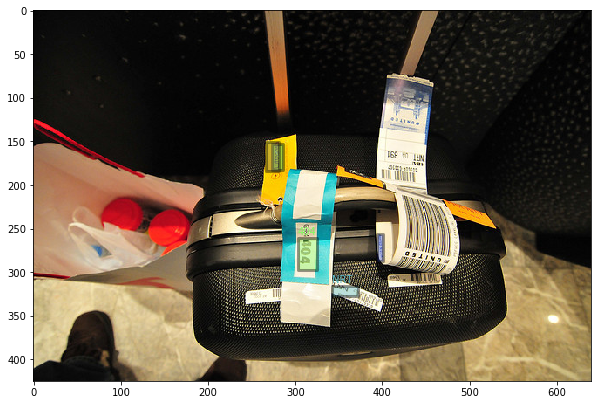

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

## get imgIds
imgIds = ct.getImgIds(imgIds=ct.train, catIds=[('legibility', 'legible')])
#idx = np.random.randint(0,len(imgIds))
idx=0
print("idx = {}".format(idx))

img = ct.loadImgs(imgIds[idx])[0]
#print(img)
## show img
I = io.imread(os.path.join(dataDir, dataType, img['file_name']))
#I = io.imread(os.path.join(dataDir, dataType, "COCO_train2014_000000022582.jpg"))
print("shape={}".format(I.shape))
plt.figure()
plt.imshow(I)

## show anns
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
print(anns)
ct.showAnns(anns)
